# Project 4, APS1070 Summer 2022
#### **Linear Regression -  15 points**
**Deadline: August 13th, 23:00**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Your **name**: Hongjian Zhu
*   Your **student number**: 1004291857



### How to submit **(HTML [This notebook] + IPYNB + GitHub [Part 7])**

1. Download your notebook: `File -> Download .ipynb`

2. Click on the Files icon on the far left menu of Colab

3. Select & upload your `.ipynb` file you just downloaded, and then obtain its path (right click) (you might need to hit the Refresh button before your file shows up)


4. execute the following in a Colab cell:
```
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb
```

5. An HTML version of your notebook will appear in the files, so you can download it.

6. Submit **both** <font color='red'>`HTML` and `IPYNB`</font>  files for this notebook on Quercus for grading.

7. Make sure you compeleted the last part on <font color='red'>**GitHub**</font> and added your link to the last cell here. The teaching team will view and grade your part 7 on GitHub.



Ref: https://stackoverflow.com/a/64487858 



## Part 1 - Getting Started [1 marks]

Ailerons are small hinged sections on the outboard portion of a wing used to control the roll of an airplane. In this project, we are going to design a controller to manage the ailerons of an aircraft based on supervised learning.

![Aileron](https://www.eecg.utoronto.ca/~hadizade/APS1070/p3Ar.jpg)




The following dataset contains 13750 instances, where each instance is a set of 40 features describing the airplane's status. Our goal is to use these features to predict the `Goal` column, which is a command that our controller should issue. We will make our predictions by implementing linear regression.

In [ ]:
import pandas as pd
import numpy as np

df=pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

Here are the steps to complete this portion:

1. Print the dataframe.
2. Prepare your dataset as follows: **[0.5]**
  *   Using `train_test_split` from Sklearn, split the dataset into training, validation, and test sets ($70\%$ training, $15\%$ validation, and $15\%$ test). When splitting, set `random_state=1`.
  *   Standardize the data using `StandardScaler` from sklearn. 
  *   Insert the first column of all $1$s in the training, validation, and test set.
 
3. Explain the difference between epoch and iteration in the Gradient descent algorithm (SGD/mini-batch)? **[0.5]**

In [ ]:
print(df.head(2)) #print the dataframe

   inputs ClimbRate  Sgz     P     Q  CurPitch  CurRoll  AbsRoll  DiffClb  \
0               -17   -6 -0.03  0.14      0.59     -0.5      -11       -9   
1              -791   15 -0.28 -0.34      1.11      0.9      -10       27   

   DiffRollRate  DiffDiffClb  ...  DiffSeTime8  DiffSeTime9  DiffSeTime10  \
0         0.015         -0.2  ...          0.0          0.0           0.0   
1        -0.002          4.7  ...          0.0          0.0           0.0   

   DiffSeTime11  DiffSeTime12  DiffSeTime13  DiffSeTime14  Alpha     Se  \
0           0.0           0.0           0.0           0.0    0.6  0.021   
1           0.0           0.0           0.0           0.0    0.4  0.013   

     Goal  
0 -0.0008  
1 -0.0009  

[2 rows x 41 columns]


In [ ]:
#Part 1.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Y = df["Goal"] # targets
#print(df.head()) #print the dataframe
X = df.loc[:,df.columns != 'Goal'] # 40 features

#Part 1.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 1) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1764, random_state = 1)
scaler = StandardScaler()
sx_train = scaler.fit_transform(x_train)
one = np.ones((sx_train.shape[0],1))
sx_train = np.hstack((one, sx_train))

sx_valid = scaler.transform(x_val)
one_v = np.ones((sx_valid.shape[0],1))
sx_valid = np.hstack((one_v, sx_valid))

Y_train = np.array(y_train)

## Part 2 - Linear Regression Using Direct Solution [1 marks]

Implement the direct solution of the linear regression problem on the training set. **[0.5]**

**Note:** You should use **``scipy.linalg.inv``** to perform the matrix inversion, as ``numpy.linalg.inv`` may cause numerical issues.

Report the root-mean-square error (RMSE) for both the training and validation sets. **[0.5]**

You may use `mean_squared_error` from Sklearn for computing the RMSE.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import scipy as sp
import matplotlib.pyplot as plt
def rmse(y,t):
  return np.sqrt(mean_squared_error(y,t))

def Direct_sol (X_train,y_train , X_valid, y_valid):
  W = np.dot(sp.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train)) # Train the model using training set: finding weights
  y_pred_train = np.dot(X_train, W) # prediction on the training set
  y_pred_valid = np.dot(X_valid, W) # prediction on the validation set
  RMSE_train = rmse(y_pred_train, y_train)
  RMSE_valid = rmse(y_pred_valid, y_valid)
  print ("RMSE on training set: " , RMSE_train)
  print ("RMSE on validation set: " , RMSE_valid)

  return W , y_pred_train , y_pred_valid , RMSE_train , RMSE_valid

Result = Direct_sol(sx_train, y_train , sx_valid, y_val)

RMSE on training set:  0.0001853303390622344
RMSE on validation set:  0.0001804099999395555


## Part 3 - Full Batch Gradient Descent [2 marks]

We will now implement a "full batch" gradient descent algorithm and record the training time for our model. Recall that the full batch gradient descent is,
 $$w_t = w_{t-1} - \alpha~g_t$$ where $\alpha$ is the learning rate and $g_t$ is your gradient, computed on the entire data. 

Here are the steps for this part:

* Implement gradient descent for linear regression using a fixed learning rate of $\alpha= 0.01$, and iterate until your model's **validation** RMSE converges. 

  We consider the gradient descent as having converged when RMSE on the validation set using gradient descent satisfies:

  $$ RMSE_\text{GD} \leq 1.001 \times RMSE_\text{Direct Solution}$$

  where $RMSE_\text{Direct Solution}$ is the RMSE on the validation set using the direct solution that you calculated in the previous part. 

  We refer to the quantity $RMSE_\text{Direct Solution}\times 1.001$ as the convergence threshold (CT).

*  Record the training time (from the first iteration until convergence) using the `time.time()` function. Be sure to compute the gradients yourself! Take a look at the code provided in the tutorial. **[0.5]**

* Plot the training RMSE and the validation RMSE vs. epoch on the same figure.  **[0.5]**

* Comment on overfitting/underfitting by observing the training and validation RMSE **[1]**

**Hint**: Initialize your weights with small random numbers (<$0.001$)

########################
training stop at 5225
rms error for training 0.00018466004829837686
rms error for validation 0.00018040937834522014
--- Total Training Time: 7.369421005249023 (s) ---


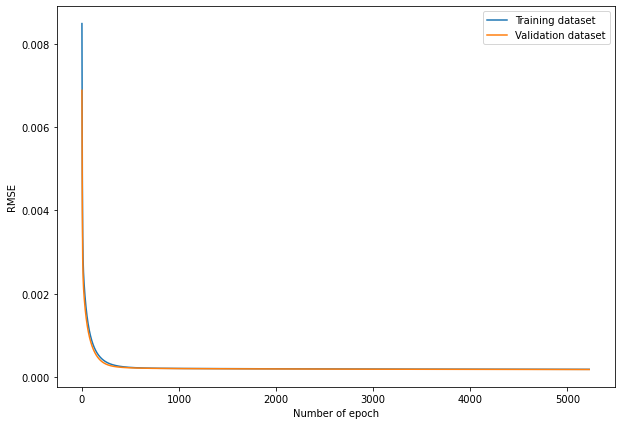

In [ ]:
import time
start_time = time.time() ## Records current time
learning_rate = 0.01
np.random.seed(5)
RMSE_target = Result[-2]
RMSE_target = RMSE_target * 1.001
RMSE_V_target = Result[-1]
def GD(rms_target, X_train,X_val, targets, val_targets):
  rms_record = [[],[]]
  W = np.random.rand(X_train.shape[1])
  W = W/1000 #initialize w to small value
  epoch = 10000
  N = len(X_train)
  count = 0
  for ix in range(epoch):
    y = np.dot(X_train,W)
    rms_train = rmse(y,targets)
    gradient = (1/N)*np.dot(X_train.T,(y-targets)) 
    W = W - learning_rate * gradient
    rms_record[0].append(rms_train)
    count += 1
    y_val = np.dot(X_val, W)
    rms_val = rmse(y_val,val_targets) #get the RMSE for validation dataset
    rms_record[1].append(rms_val)
    if (rms_val < rms_target):
      break

  print('########################')
  print('training stop at {}'.format(count))
  print('rms error for training', rms_train)
  print('rms error for validation', rms_val)
  return rms_record,W
  
RMS,W = GD(RMSE_V_target, sx_train, sx_valid, y_train, y_val)
print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))
#print('Ws are',W)
x_axis = np.arange(len(RMS[0]))
plt.figure(figsize=(10,7))
plt.plot(x_axis, RMS[0], label = 'Training dataset')
plt.plot(x_axis, RMS[1], label = 'Validation dataset')
plt.legend()
plt.xlabel('Number of epoch')
plt.ylabel('RMSE')
plt.show()


**Discussion for Part 3**

Based on the plot and RMSE value, the model is well trained, RMSE for validation dataset is less than training dataset. The model is neither under-fitting nor over-fitting


## Part 4 - Mini-batch and Stochastic Gradient Descent [4 marks]

Write a function that performs mini-batch gradient descent until the convergence threshold (CT) is reached. **[1]**

The inputs of that function are: 
  * Input data (training/validation), Batch size, Learning Rate, Convergence Threshold (CT)

Your function will return the following arrays: 
 * The final weights after training.
 * The training RMSE at each epoch.
 * The validation RMSE at each epoch.
 * An array that has the elapsed time from the start of the training process to the end of each epoch (e.g., if each epoch takes exactly 2 seconds, the array would look like: [2 4 6 8 ...]).

Notes: 
* For certain batch sizes, GD might not converge to a solution. For that reason, you need to check the RMSE of the validation/training set at each epoch, and if it's getting larger and larger, you should stop the training for that case (the design is up to you!).
* CT will help you to know when your model is converged. 
* **Important: after each epoch, you need to shuffle the entire training set.** This ensures that new mini-batches are selected for every epoch. Hint: use `np.random.permutation`. 

Let's now use the function to investigate the effect of batch size on convergence. When the batch size is 1, we call that stochastic gradient descent. When the batch size equals the # of training data, it is full-batch (i.e., all data points are used at every iteration). Anywhere in between is mini-batch (we use some of the data).
  * Sweep different values for the mini-batch size (at least 5 values that **converge**), each time using a learning rate of $\alpha= 0.01$. **Hint: Try batch sizes that are powers of two (e.g., 2,4,8,16,32,64,128...).** These batch sizes fit better on the hardware and may achieve higher performance.  **[0.5]**

Provide the following $3$ plots:
  1.  Plot training and validation RMSE vs. **epoch** for all the **converging** batch sizes (some batch sizes might not converge) in a figure. The X-axis is Epoch # and the Y-axis is RMSE. **[0.5]**
  2. Plot training and validation RMSE vs. **time** for all the **converging** batch sizes in a figure. The X-axis is Time, and the Y-axis is RMSE. **[0.5]**
  3. Plot Total training time (y-axis) vs. Batch size (x-axis). **[0.5]**

Describe your findings, including the main takeaways from each of your plots. **[1]**

In [ ]:
from sklearn.model_selection import StratifiedKFold
import math
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
np.random.seed(1)

def mini_batch_GD(train_data, batch_size, targets, learning_rate, CT, epochs):

  W = np.random.rand(train_data.shape[1])
  W = W/1000 #initialize w to small value
  n_batches = int(math.ceil(len(train_data)/batch_size))
  rms_list, elapsed_Time = [], []
  RMS_LIST = []
  start_time = time.time() ## Records current time
  Epoch = []
  count = 0
  Overflow=False
  for ix in range(epochs):
    head = 0
    for index in range(1,n_batches):
      tail = index*batch_size
      target = targets[head:tail]
      x = train_data[head:tail]
      y = np.dot(x,W)
      N = len(y)
      
      gradient = np.dot(x.T,(y-target))/N
      if(np.amax(gradient) == np.inf):
        Overflow = True
        break
      W = W - learning_rate * gradient
      head = tail
    if(Overflow):
      print('\nGradient Overflow! Divergence at batchsize {}'.format(batch_size))
      break
      
    permutation_order = list(np.random.permutation(targets.shape[0]))
    train_data = train_data[permutation_order]
    targets = targets[permutation_order]
    count += 1
    Epoch.append(count) #record number of epochs

    endTime = time.time() - start_time
    elapsed_Time.append(endTime)#record time usage for each epoch

    Y_val = np.dot(sx_valid, W)
    RMS_V = rmse(Y_val, y_val)
    rms_list.append(RMS_V)

    y = np.dot(train_data,W)
    RMS = rmse(y,targets)
    RMS_LIST.append(RMS)

    if(RMS_V<CT):
      print('\n Batch Size {} Model converage at epoch{}'.format(batch_size,ix))
      break
    elif(ix > 5 and RMS_V > rms_list[-2] and rms_list[-2] > rms_list[-3] and rms_list[-3] > rms_list[-4]):
      print(rms_list)
      print('\n Batch Size {} Model is divergence'.format(batch_size))
      print('End at epoch{}'.format(ix))
      break

  if(not Overflow): 
    if(RMS_V > CT):
      print('\n Batch Size {} Reach maximum epochs'.format(batch_size))
    print('final va: {},tr: {}'.format(RMS_V,RMS))
  return W, RMS_LIST, rms_list, elapsed_Time

[154.085421210552, 143382.28030884836, 1753846876.774714, 33400900386842.98, 3.1290075004855443e+17, 1.600174761079315e+21, 1.8665634544875002e+24]

 Batch Size 2 Model is divergence
End at epoch6

 Batch Size 2 Reach maximum epochs
final va: 1.8665634544875002e+24,tr: 5.0563160069206494e+26
[0.1387146485213731, 10.55385052309187, 98636.0622012584, 7067539.932602169, 32522274430.53895, 8905385885484.244, 3660055620104685.5]

 Batch Size 4 Model is divergence
End at epoch6

 Batch Size 4 Reach maximum epochs
final va: 3660055620104685.5,tr: 2.955221721017321e+17
[0.00025568562692325264, 0.036993348189026186, 2.2071415812636244, 905.1977816858466, 3136.6442175471157, 88551.2525615701, 15287405.015657844]

 Batch Size 8 Model is divergence
End at epoch6

 Batch Size 8 Reach maximum epochs
final va: 15287405.015657844,tr: 492570660.2212429
[0.0002614020313880204, 0.002349349696305773, 0.01412358669664789, 0.039532207652330446, 0.30514618884356903, 0.977785671684181, 22.48774211979399]

 Ba

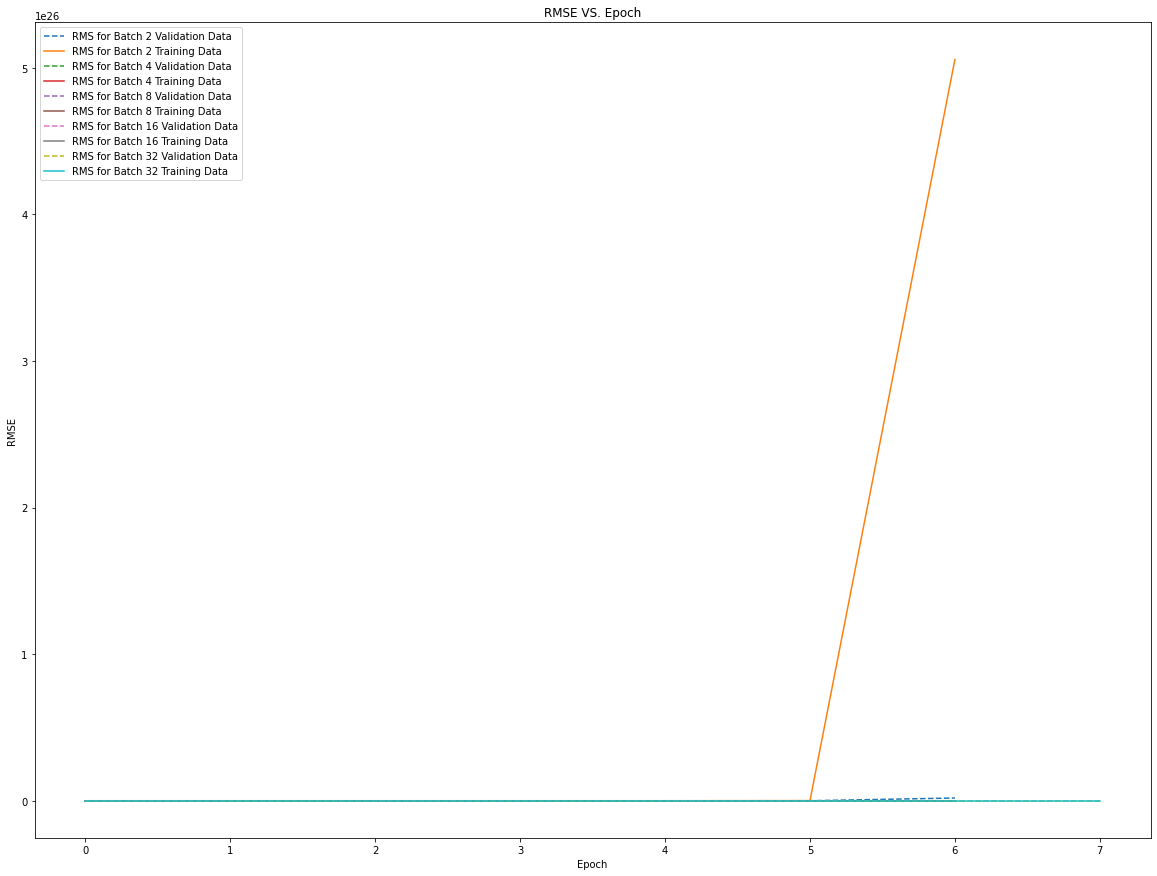

In [ ]:
Batch_size = [2,4,8,16,32]
W_total, RMS_total = [],[]
RMS_V_total, E_Time = [],[]
#RMSE_V_target
  
plt.figure(figsize=(20,15))
for ix in Batch_size:    
  W, RMS, RMS_V, elapsed_Time = mini_batch_GD(sx_train,ix,Y_train, 0.01,RMSE_V_target, 1000)
  W_total.append(W)
  RMS_total.append(RMS)
  RMS_V_total.append(RMS_V)
  E_Time.append(elapsed_Time)

  Epoch = np.arange(len(RMS))
  plt.plot(Epoch, RMS_V,'--',label='RMS for Batch {} Validation Data'.format(ix))
  plt.plot(Epoch, RMS,label='RMS for Batch {} Training Data'.format(ix))

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE VS. Epoch')
plt.legend()
plt.show()

**Batch size of 2, 4, 8 , 16 and 32 are diverged at learning rate of 0.01**



 Batch Size 64 Model converage at epoch40
final va: 0.0001800112992441059,tr: 0.00023064748780041194

 Batch Size 128 Model converage at epoch35
final va: 0.00018033738331557544,tr: 0.00018353951987355177

 Batch Size 256 Model converage at epoch92
final va: 0.00018022690195219614,tr: 0.00018284474868881316

 Batch Size 512 Model converage at epoch274
final va: 0.00018034190691358206,tr: 0.0001849717551336541

 Batch Size 1024 Model converage at epoch543
final va: 0.00018034376013978452,tr: 0.0001838277114601823

 Batch Size 2048 Model converage at epoch967
final va: 0.00018039696373441506,tr: 0.00018422098924155255


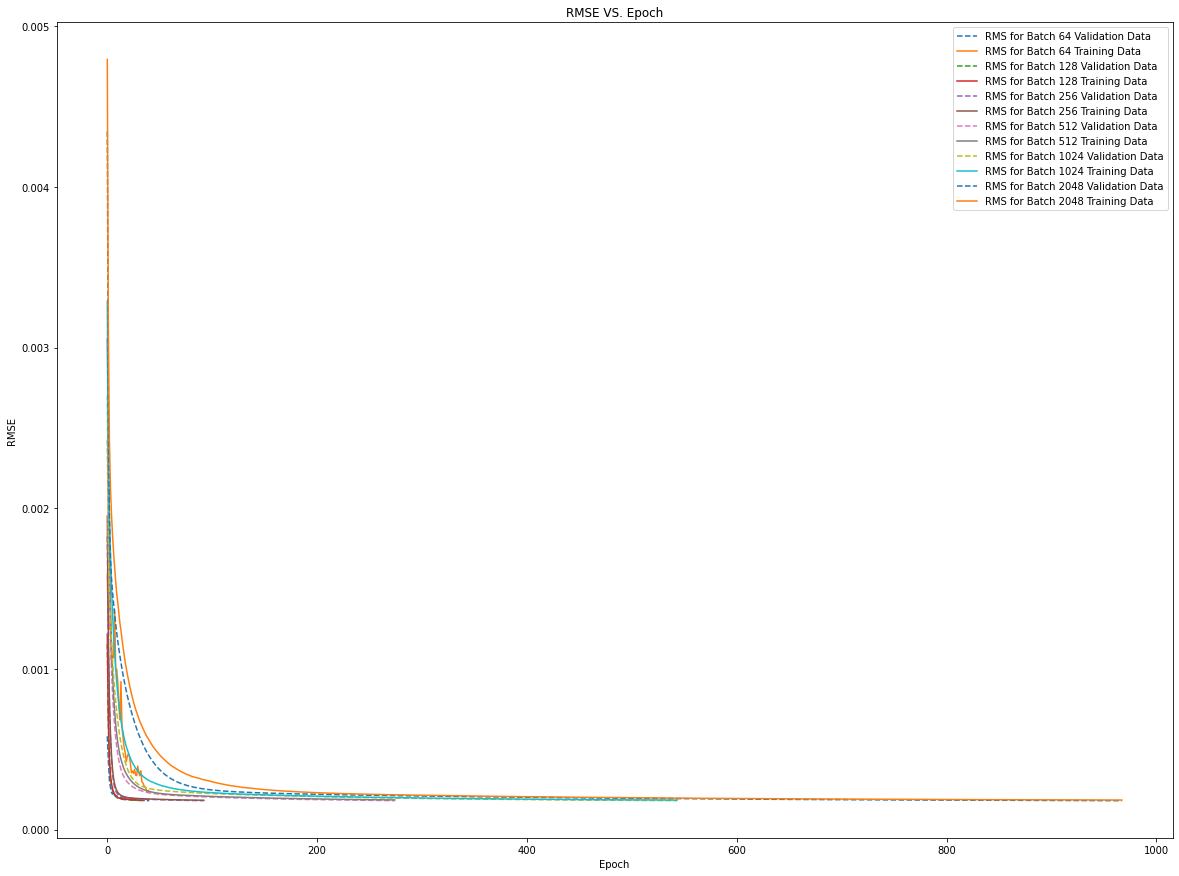

In [ ]:
Batch_size = [64,128,256,512,1024, 2048]
W_total, RMS_total = [],[]
RMS_V_total, E_Time = [],[]
#RMSE_V_target
  
plt.figure(figsize=(20,15))
for ix in Batch_size:    
  W, RMS, RMS_V, elapsed_Time = mini_batch_GD(sx_train,ix,Y_train, 0.01,RMSE_V_target, 1000)
  W_total.append(W)
  RMS_total.append(RMS)
  RMS_V_total.append(RMS_V)
  E_Time.append(elapsed_Time)

  Epoch = np.arange(len(RMS))
  plt.plot(Epoch, RMS_V,'--',label='RMS for Batch {} Validation Data'.format(ix))
  plt.plot(Epoch, RMS,label='RMS for Batch {} Training Data'.format(ix))

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE VS. Epoch')
plt.legend()
plt.show()

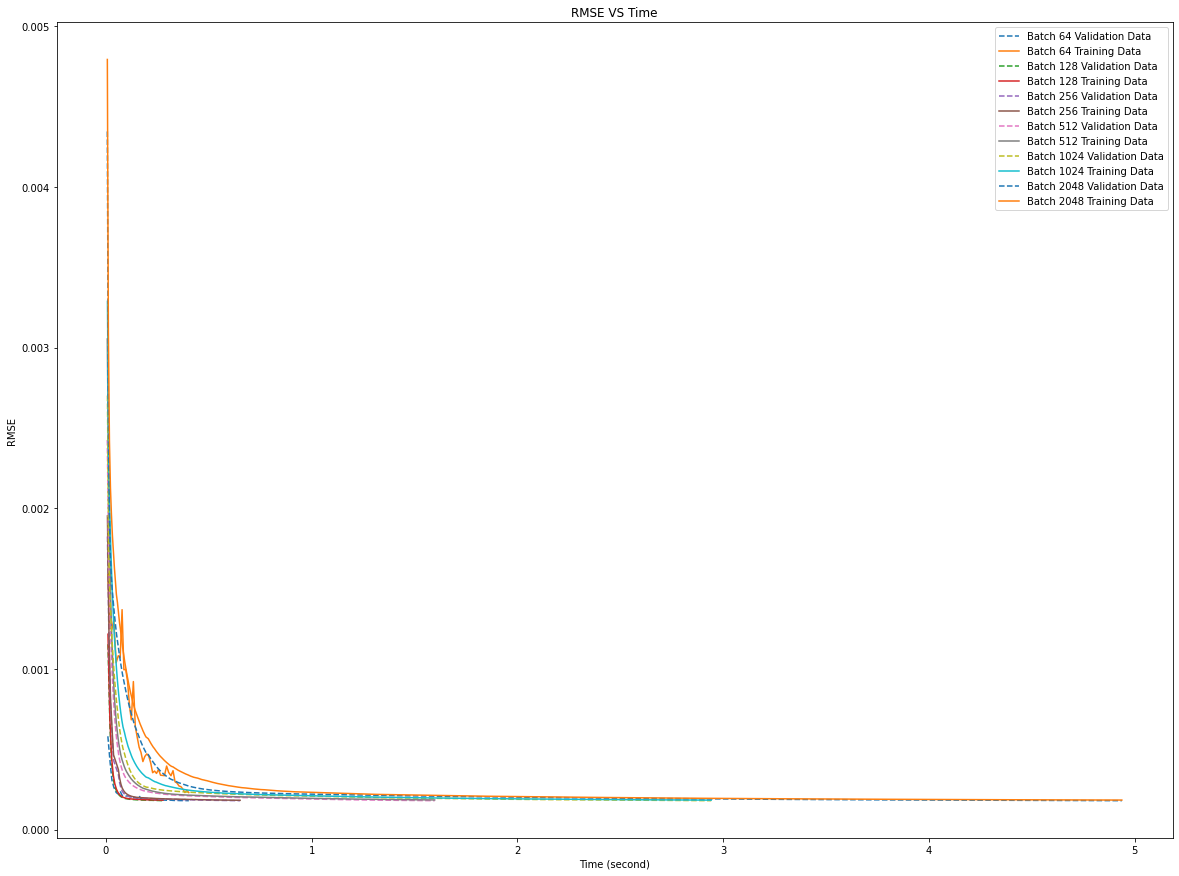

In [ ]:
plt.figure(figsize=(20,15))
for c,v in enumerate(Batch_size):    
  plt.plot(E_Time[c], RMS_V_total[c],'--',label='Batch {} Validation Data'.format(v))
  plt.plot(E_Time[c], RMS_total[c],label='Batch {} Training Data'.format(v))
plt.xlabel('Time (second)')
plt.ylabel('RMSE')
plt.title('RMSE VS Time')
plt.legend()
plt.show()

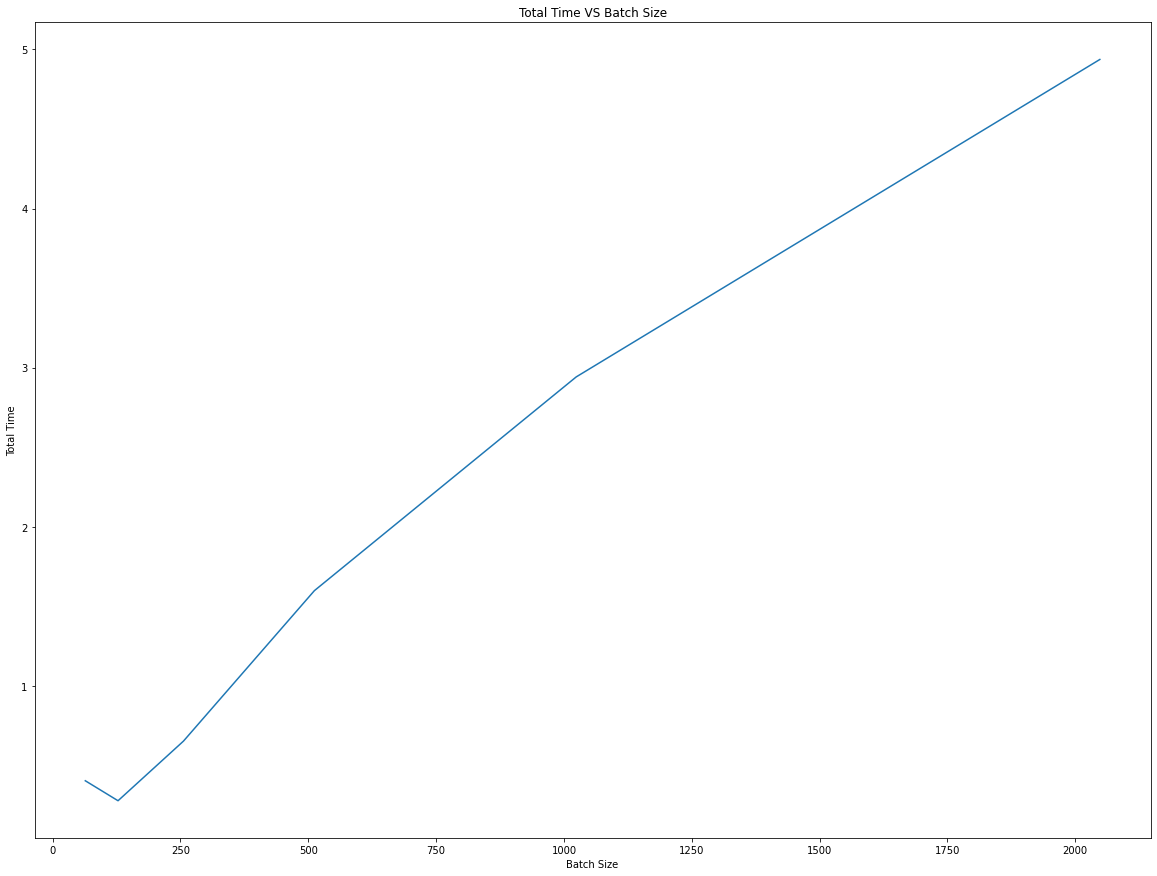

In [ ]:
plt.figure(figsize=(20,15))
Time = []
for ix in range(len(E_Time)):
  Time.append(E_Time[ix][-1])

plt.plot(Batch_size,Time)

plt.xlabel('Batch Size')
plt.ylabel('Total Time')
plt.title('Total Time VS Batch Size')
plt.show()

**Part 4 Discussion**


A. Relationship between RMSE and Epoch at fixed learning rate

When learning rate is fixed at 0.01, smaller batch size takes less epochs to converge at the threshold. It also match the expectation that minibatch model is more efficient than full batch model. 

B. Relationship between RMSE and total time

In general, if the model is converged, RMSE will drop significantly as traing time increase. From the second plot, we know large batch size model tends to take longer to converge at fixed learning rate which make sense as they require more epochs to converge as discussed in part 4.a

C. Relationship between Total time and Batch size

From the last plot, we learn the total runtime is propotional to the increase of batch size. In this dataset, model with batch size of 128 has the lowest total time. 

## Part 5 - Gradient Descent Learning Rate [2 marks]
Use the function that you designed in Part 4 to investigate the effect of learning rate on convergence.

1. Pick 3 batch sizes that do not converge with a learning rate of $\alpha= 0.01$ (last part) and try to find a learning rate that results in convergence for each batch size. Report your findings in a table. Mention batch size, learning rate, and training and validation RMSE. **[0.5]**

2. Select the best batch size based on Part 4's fastest convergence time and sweep the learning rate (at least 10 values, all should converge) while applying Mini-batch GD. 
  
  * Plot the training and validation RMSE vs. **epoch** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  * Plot the training and validation RMSE vs. **time** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  * Describe your findings, including the main takeaways from each of your plots. **[0.5]**

Batch size of 2, 4 and 8 are diverged in Part 4 at learning rate of 0.01

In [ ]:
def LR_mini_batch_GD(train_data, batch_size, targets, learning_rate, CT, epochs):

  W = np.random.rand(train_data.shape[1])
  W = W/1000 #initialize w to small value
  n_batches = int(math.ceil(len(train_data)/batch_size))
  rms_list, elapsed_Time = [], []
  RMS_LIST = []
  start_time = time.time() ## Records current time
  Epoch = []
  count = 0
  Converage = False
  for ix in range(epochs):
    head = 0
    for index in range(1,n_batches):
      tail = index*batch_size
      target = targets[head:tail]
      x = train_data[head:tail]
      y = np.dot(x,W)
      N = len(y)
      
      gradient = np.dot(x.T,(y-target))/N
      W = W - learning_rate * gradient
      head = tail

    permutation_order = list(np.random.permutation(targets.shape[0]))
    train_data = train_data[permutation_order]
    targets = targets[permutation_order]
    count += 1
    Epoch.append(count) #record number of epochs
    endTime = time.time() - start_time
    elapsed_Time.append(endTime)#record time usage for each epoch
    Y_val = np.dot(sx_valid, W)
    RMS_V = rmse(Y_val, y_val)
    rms_list.append(RMS_V)
    y = np.dot(train_data,W)
    RMS = rmse(y,targets)
    RMS_LIST.append(RMS)
    if(RMS_V<CT):
      print('\n Batch Size {} Model converage at epoch{} with learning rate of {}'.format(batch_size,ix,learning_rate))
      Converage = True
      break
    elif(ix > 5 and RMS_V > rms_list[-2] and rms_list[-2] > rms_list[-3] and rms_list[-3] > rms_list[-4]):
      '''
      print('\n Batch Size {} Model is divergence'.format(batch_size))
      print('End at epoch{}'.format(ix))
      '''
      break

  #print('final va: {},tr: {}'.format(RMS_V,RMS))
  return W, RMS_LIST, rms_list, elapsed_Time, Converage


 Batch Size 2 Model converage at epoch112 with learning rate of 0.0001

 Batch Size 4 Model converage at epoch147 with learning rate of 0.0001

 Batch Size 4 Model converage at epoch46 with learning rate of 0.0005

 Batch Size 8 Model converage at epoch276 with learning rate of 0.0001

 Batch Size 8 Model converage at epoch97 with learning rate of 0.0005

 Batch Size 8 Model converage at epoch32 with learning rate of 0.001


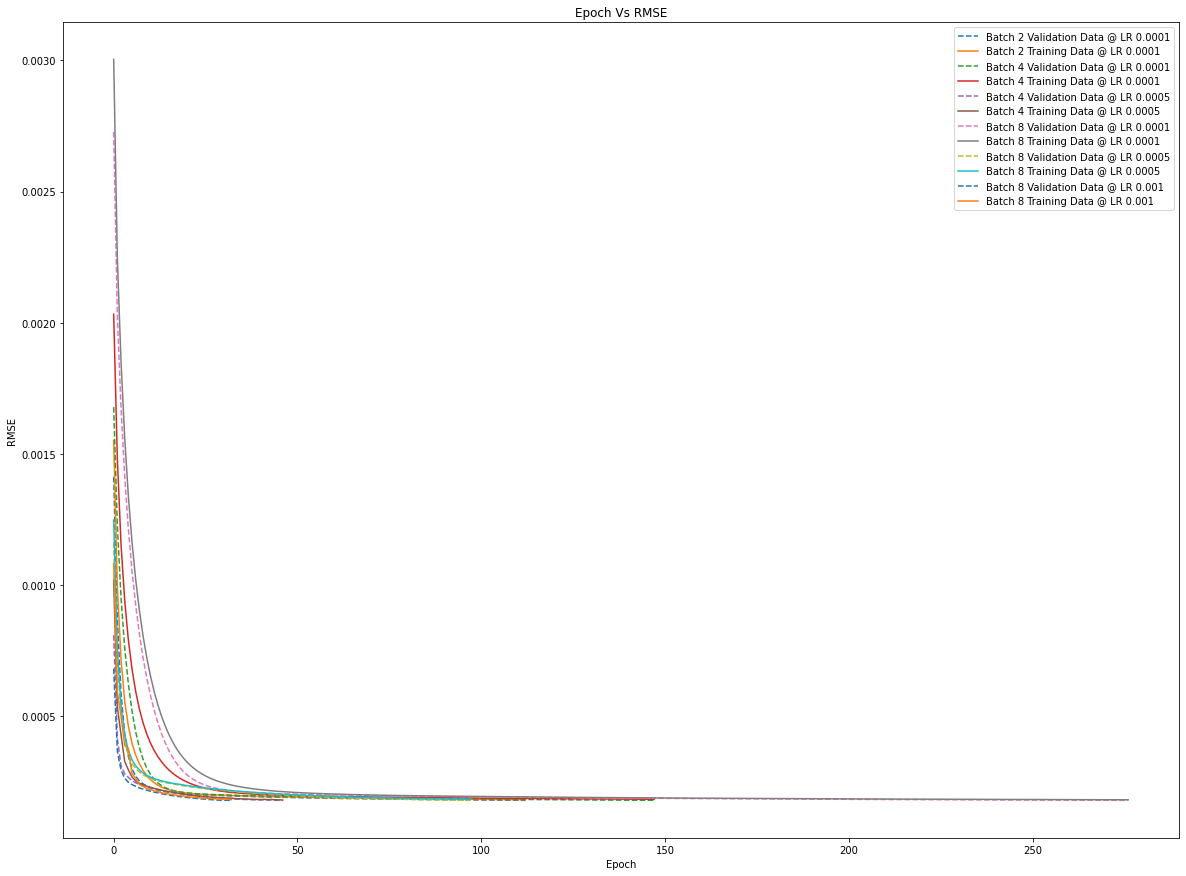

In [ ]:
import time
Batch_Size = [2,4,8]
LR = [0.0001, 0.0005, 0.001, 0.005,0.01]
RMSE_T, RMSE_V = [],[]
rmse_T, rmse_V = [],[]
TIME,ttime = [],[]
BATCH = []
Learning_Rate = []
plt.figure(figsize=(20,15))
for ix in Batch_Size:
  for lr in LR:
    W, RMS, RMS_V, elapsed_Time,C = LR_mini_batch_GD(sx_train,ix,Y_train, lr ,RMSE_V_target, 1000)
    if(C):
      Epoch = np.arange(len(RMS))
      TIME.append(elapsed_Time)
      BATCH.append(ix)
      RMSE_T.append(RMS)
      RMSE_V.append(RMS_V)
      rmse_T.append(round(RMS[-1],5))
      rmse_V.append(round(RMS_V[-1],5))
      ttime.append(round(elapsed_Time[-1],4))
      Learning_Rate.append(lr)
      plt.plot(Epoch, RMS_V,'--',label='Batch {} Validation Data @ LR {}'.format(ix,lr))
      plt.plot(Epoch, RMS,label='Batch {} Training Data @ LR {}'.format(ix,lr))

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Epoch Vs RMSE')
plt.legend()
plt.show()

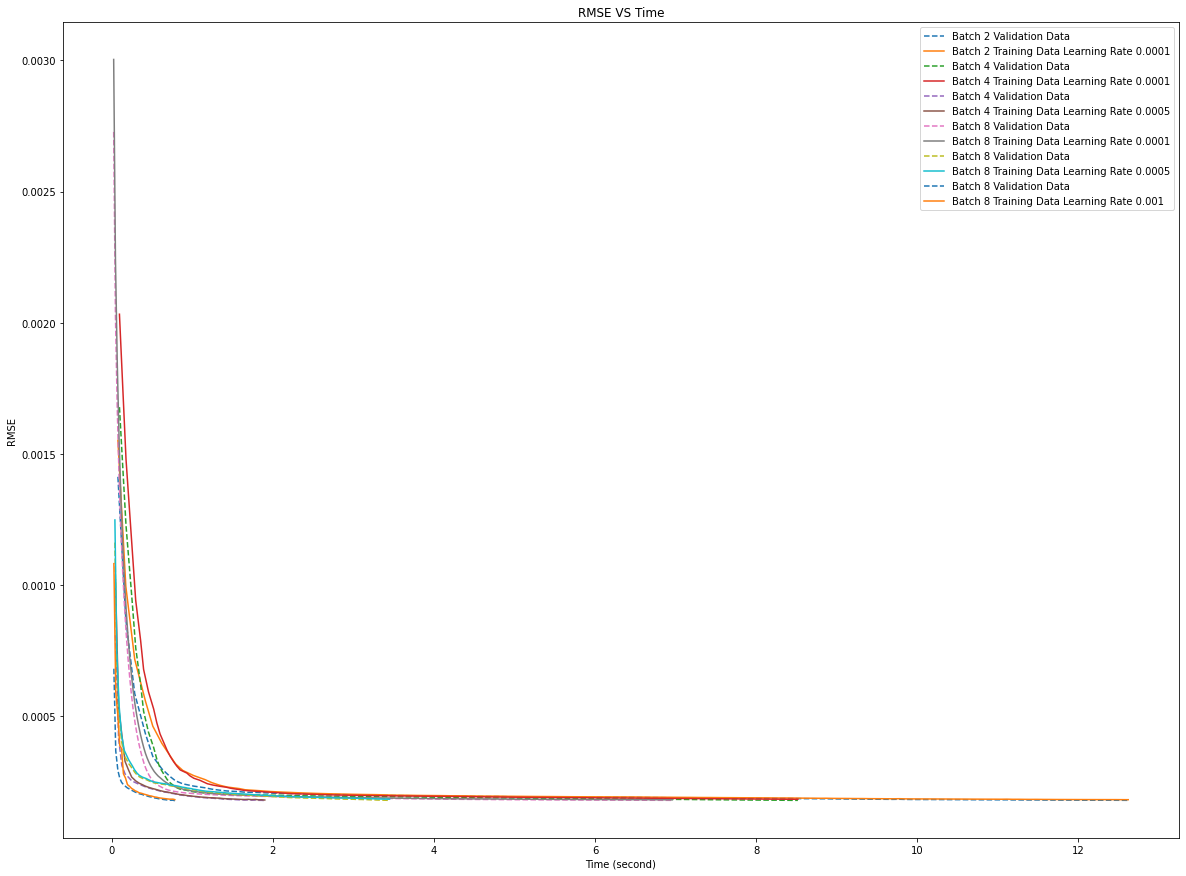

In [ ]:
plt.figure(figsize=(20,15))
for c,v in enumerate(RMSE_T):    
  plt.plot(TIME[c], RMSE_V[c],'--',label='Batch {} Validation Data'.format(BATCH[c],Learning_Rate[c]))
  plt.plot(TIME[c], RMSE_T[c],label='Batch {} Training Data Learning Rate {}'.format(BATCH[c],Learning_Rate[c]))
plt.xlabel('Time (second)')
plt.ylabel('RMSE')
plt.title('RMSE VS Time')
plt.legend()
plt.show()

In [ ]:
Table = {'Batch Size':BATCH, 'Learning Rate': Learning_Rate, 'RMSE for Validation':rmse_V, 'RMSE for Training':rmse_T, 'Time':ttime}
T = pd.DataFrame(data=Table)
T

,Batch Size,Learning Rate,RMSE for Validation,RMSE for Training,Time
0,2,0.0001,0.00018,0.00018,12.6191
1,4,0.0001,0.00018,0.00018,8.5185
2,4,0.0005,0.00018,0.00018,1.9010
3,8,0.0001,0.00018,0.00018,6.9584
4,8,0.0005,0.00018,0.00018,3.4506
5,8,0.0010,0.00018,0.00018,0.7846


**Part 5.2.c Discussion**

A. RMSE and Batch size at different learning rate

Based on the result from part 5, model with small batch size can converage only if the learning rate is small. It is resonable because if the batch size is small, it is more likely to update the weight at each epoch. Therefore, having small learaning rate will help the model converge

B. RMSE and total training time with different learning rate

The second plot and the table shows a model at a fixed batch size, increase its learning rate leads to less training time. Meanwhile, small batch size is not effecient for our dataset where batch size of 8 is much faster than batch size of 2 at learning rate of 0.0001





## Part 6 - Finalizing a model [2 marks]
Based on your findings from the previous parts, pick a model (or combination of model settings) that you think would work best for our dataset and evaluate it on the test set. 

Briefly describe your model selections/settings. **[1]** 

Summarize the performance of your model for the task of managing ailerons of an aircraft. **[1]** 

In [ ]:
#Part 6
Learning_rate = 0.015
BS = 128

W, RMS, RMS_V, elapsed_Time = mini_batch_GD(sx_train,BS,Y_train, Learning_rate,RMSE_V_target, 1000)

sx_test = scaler.transform(x_test)
one_v = np.ones((sx_test.shape[0],1))
sx_test = np.hstack((one_v, sx_test))
print('Total Runtime {}'.format(elapsed_Time[-1]))
print('\n Result for training dataset {}'.format(RMS[-1]))
print('\n Result for validation dataset {}'.format(RMS_V[-1]))

y_Test = np.dot(sx_test,W)
Rmse_Test = rmse(y_Test, y_test)
print('\n Result for test dataset {}'.format(Rmse_Test))


 Batch Size 128 Model converage at epoch32
final va: 0.00018040600275677138,tr: 0.00018627185093874325
Total Runtime 0.42816948890686035

 Result for training dataset 0.00018627185093874325

 Result for validation dataset 0.00018040600275677138

 Result for test dataset 0.00017826931740607118


**Setting**

I pick batch size of 128 and learning rate of 0.015

**Summary**

From the result in the part 4 and 5, we know that the dataset can be converged in most of the batch size and learning rate. Based on the result in part 4, we know the model is efficient to converge when batch size is around 128. 

In the following section, we know having a larger learning rate can help the model reaching its optimal weight. But we need to pay attention that the learing rate is not too big and lead to divergence. 

Therefore, I pick the learing rate of 0.015 instead of 0.01 in part 6. The resulting RMSE for test data is less than the CT and model train time is 0.42 seconds


## Part 7 - Getting started with Github  [3 marks]

This your private repository to get this part questions and upload your answers. **Copy this link to the text box below to be graded for this part.**
```
https://github.com/APS-1070-2021/project-4-HongjianZz
```

